In [1]:
from runSpatialSimulation_v3 import *
from spatial_yeast_model_carryingcapactiyfixed_v4 import *

In [15]:
def quick_two_strain_relay():
    strain_library = create_strain_library()
    
    # Create smaller model
    model = SpatialMultiStrainModel(grid_size=(10, 10), dx=1)
    
    # Add strains
    model.add_strain(strain_library['beta->alpha'])  # Sender
    model.add_strain(strain_library['alpha->venus']) # Receiver
    
    # Place sender strain on the left
    model.place_strain(1, 3, 3, radius=2, concentration=10.0)
    
    # Place receiver strain on the right
    model.place_strain(1, 7, 7, radius=2, concentration=10.0)
    
    # Place beta-estradiol input
    model.place_molecule(BETA, 5, 5, radius=5, concentration=100.0)
    
    # Set shorter simulation time
    model.set_simulation_time(0, 24)
    
    # Run simulation with fewer time points
    results = model.simulate(n_time_points=10, competition = False)
    
    # Plot just the final state
    model.plot_spatial_results(results, time_idx=-1, molecules=[ALPHA, BETA, VENUS])
    gfp_anim = model.create_animation(results, molecule=VENUS, 
                                       interval=100, cmap='viridis')
    gfp_anim.save('venus_alphatwostrain_stacked_diffusion.gif', writer='ffmpeg', fps=5)
    alpha_anim = model.create_animation(results, molecule=ALPHA, 
                                       interval=100, cmap='viridis')
    alpha_anim.save('alpha_alphatwostrain_stacked_diffusion.gif', writer='ffmpeg', fps=5)
    beta_anim = model.create_animation(results, molecule=BETA, 
                                       interval=100, cmap='viridis')
    beta_anim.save('beta_alphatwostrain_stacked_diffusion.gif', writer='ffmpeg', fps=5)

    return results, model

Starting spatial simulation with 2 strains...
Using model with independent carrying capacities
Simulation completed in 16.73 seconds


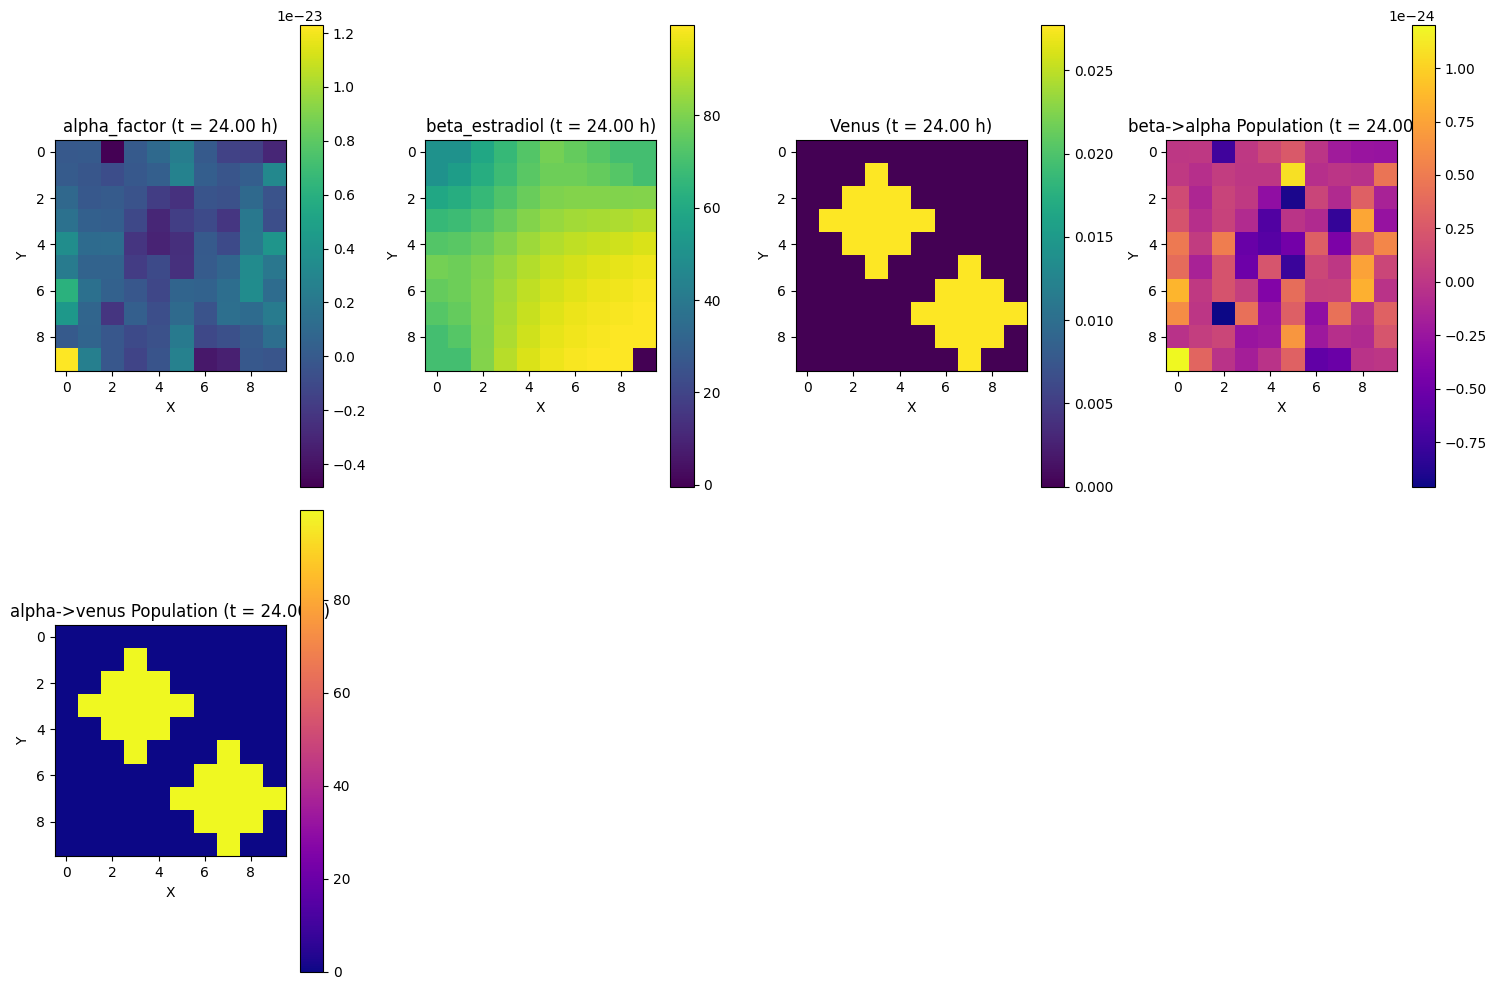

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


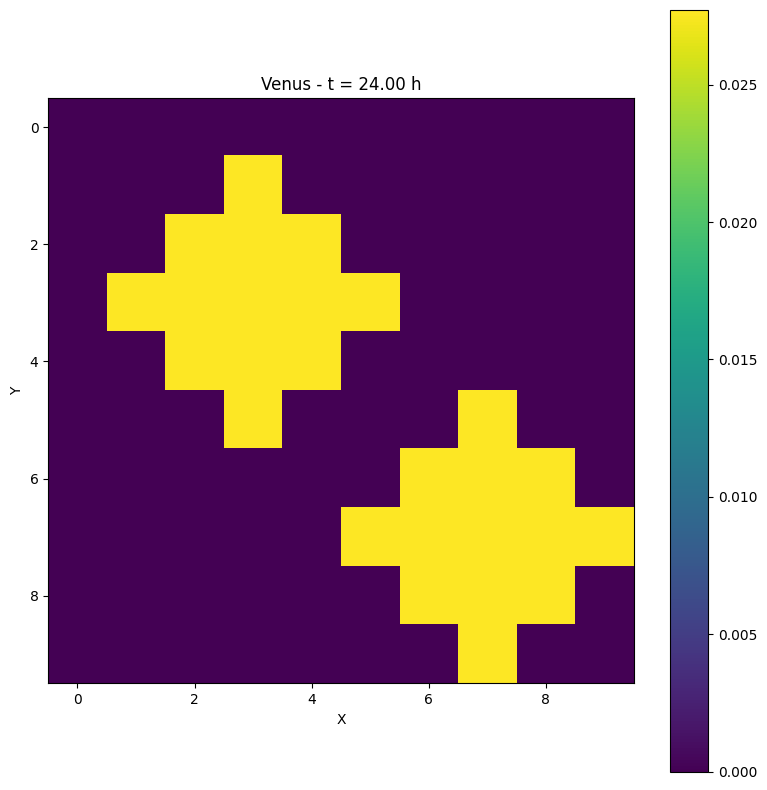

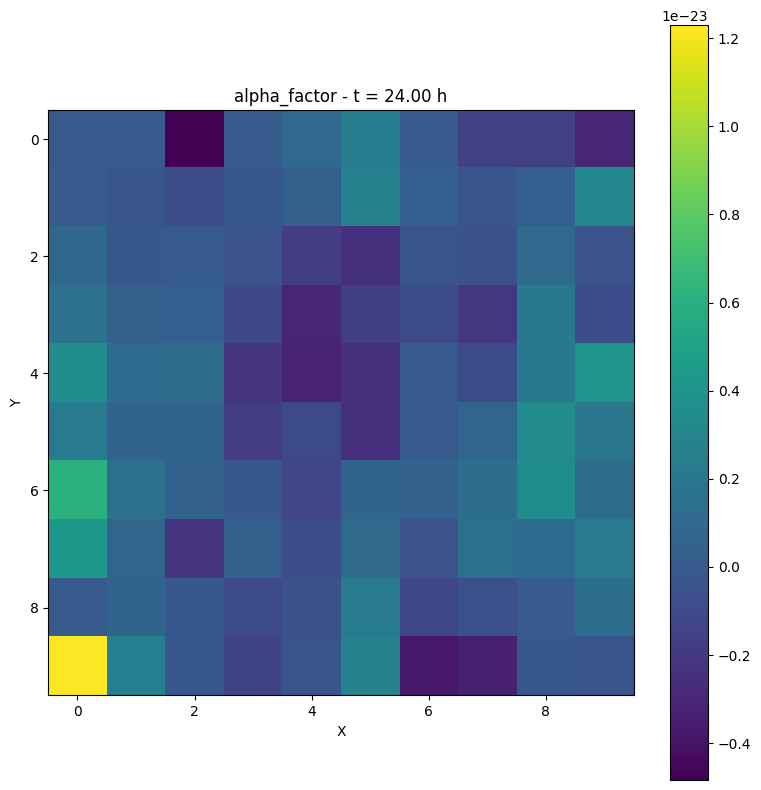

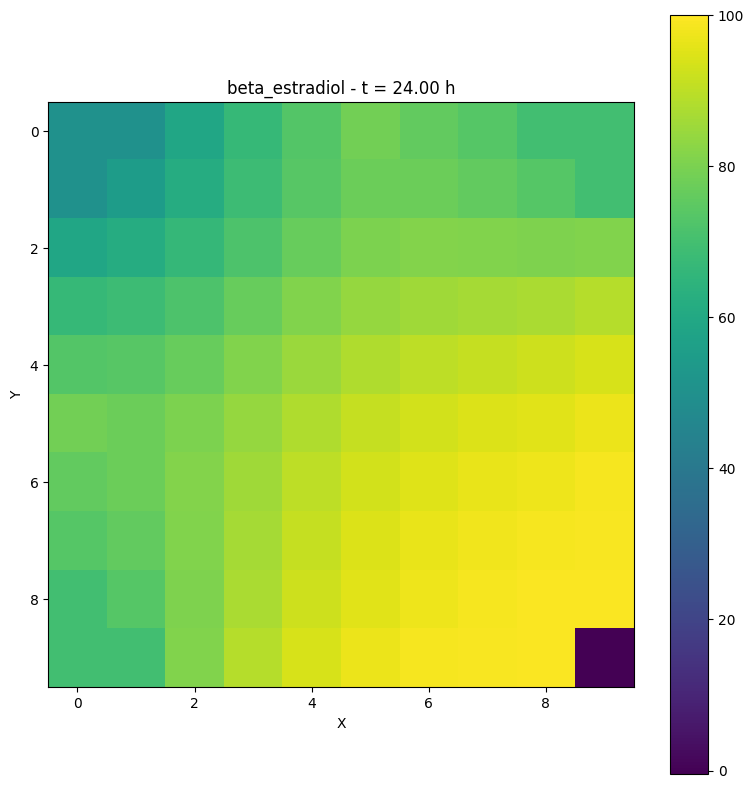

In [16]:
resultsnocomp, modelnocomp = quick_two_strain_relay()

Starting spatial simulation with 2 strains...
Using model with strain competition for carrying capacity
Simulation completed in 122.29 seconds


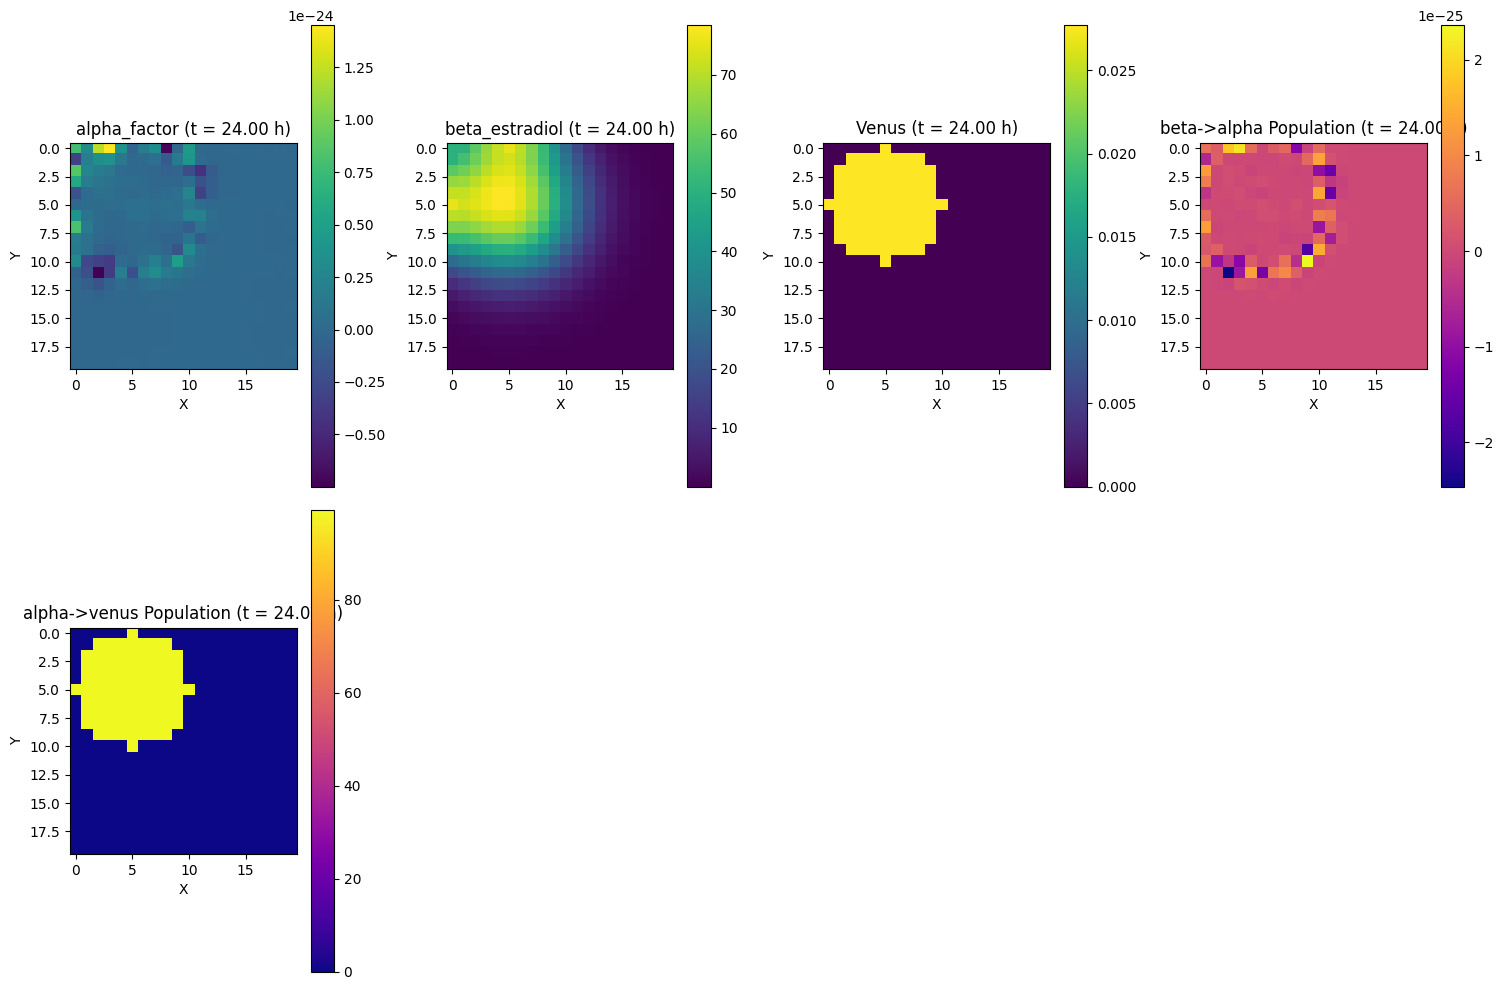

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


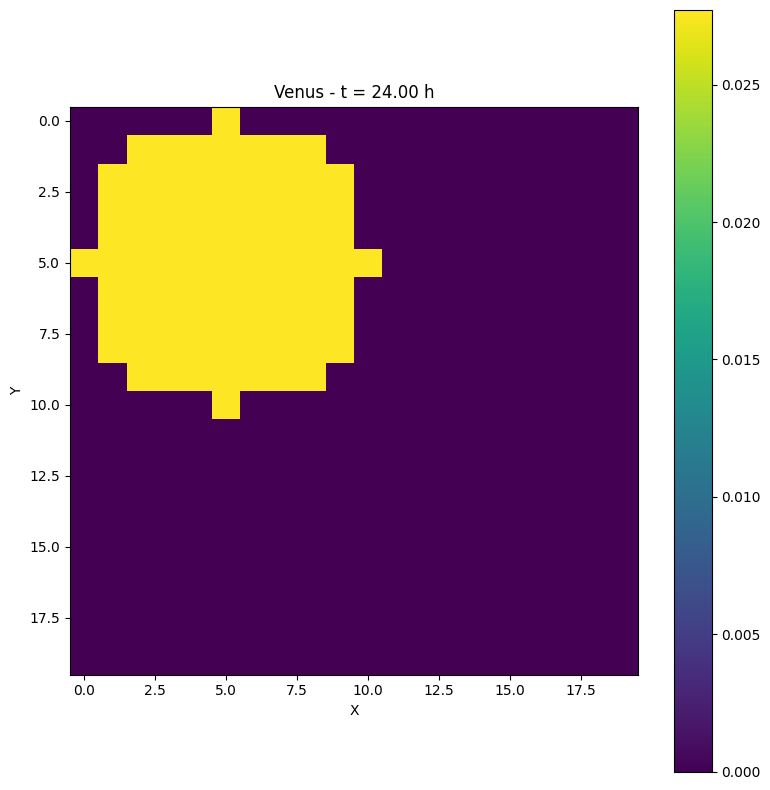

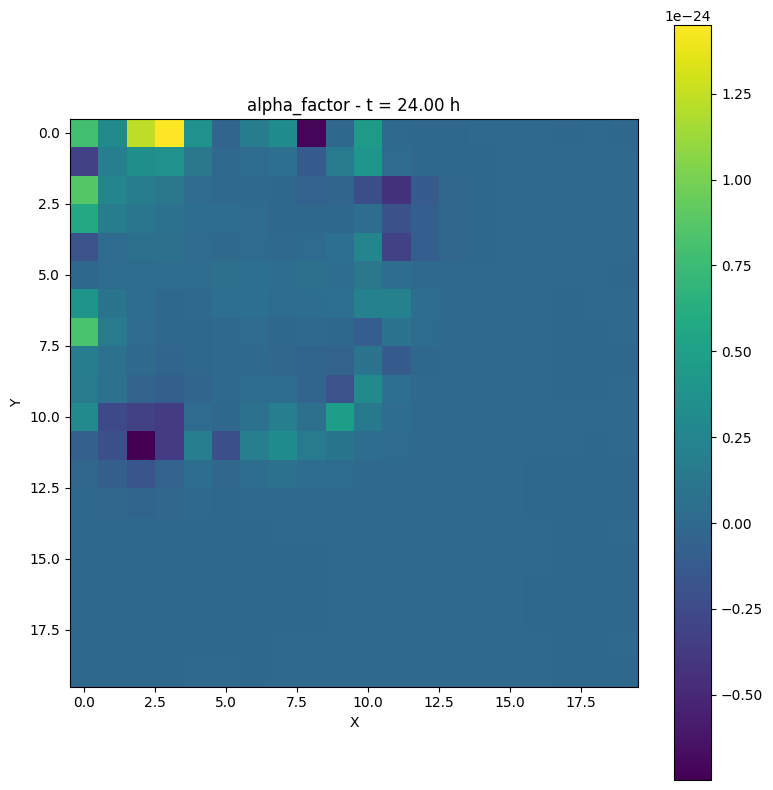

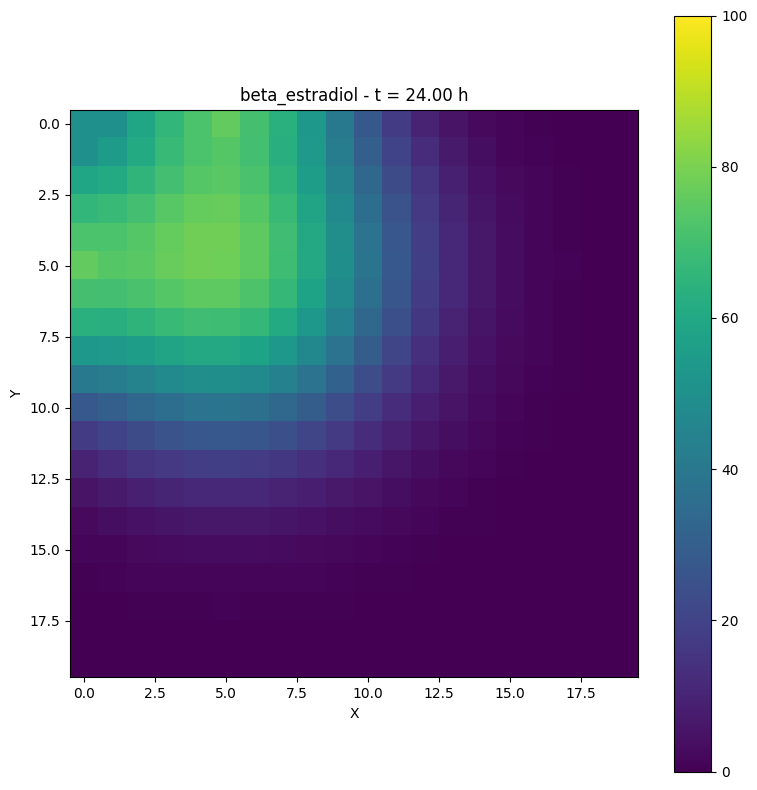

In [12]:
results, model = quick_two_strain_relay()

Starting spatial simulation with 2 strains...
Using model with strain competition for carrying capacity
Simulation completed in 140.96 seconds


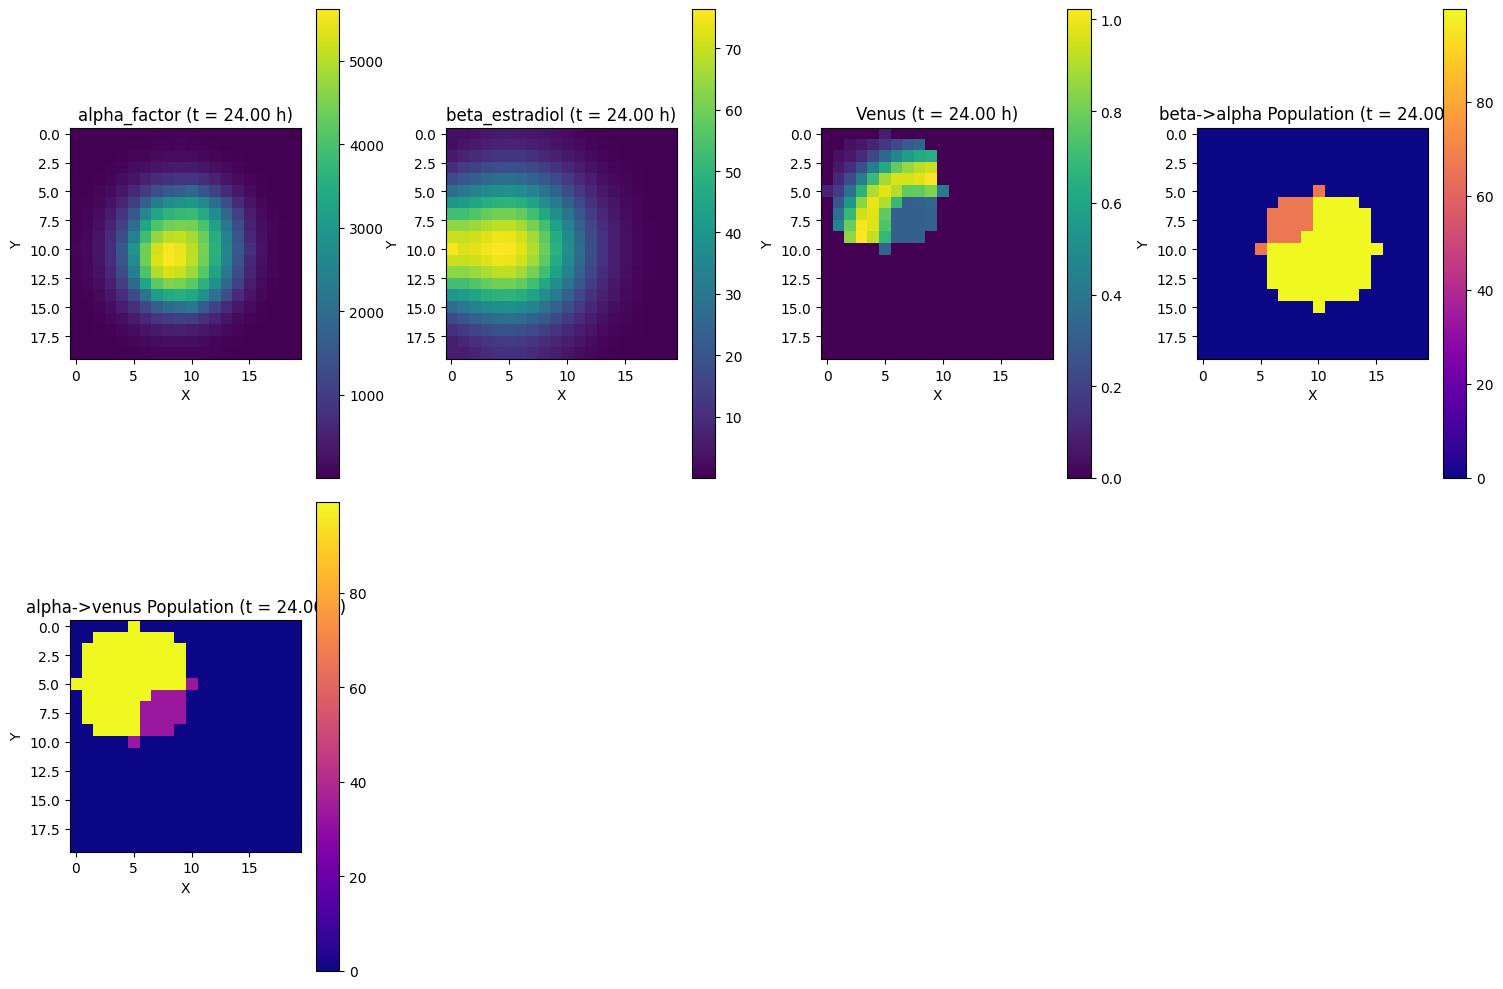

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


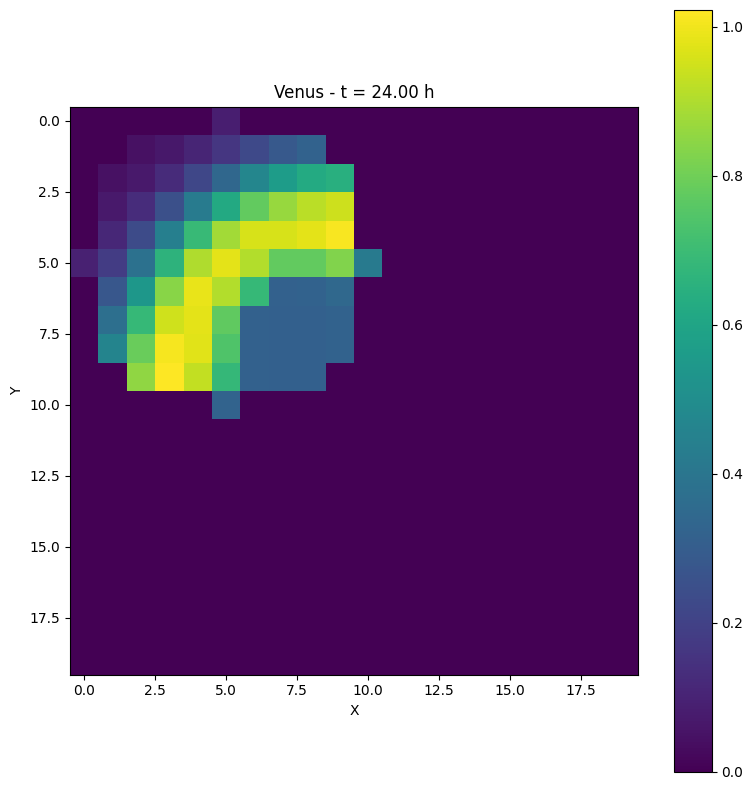

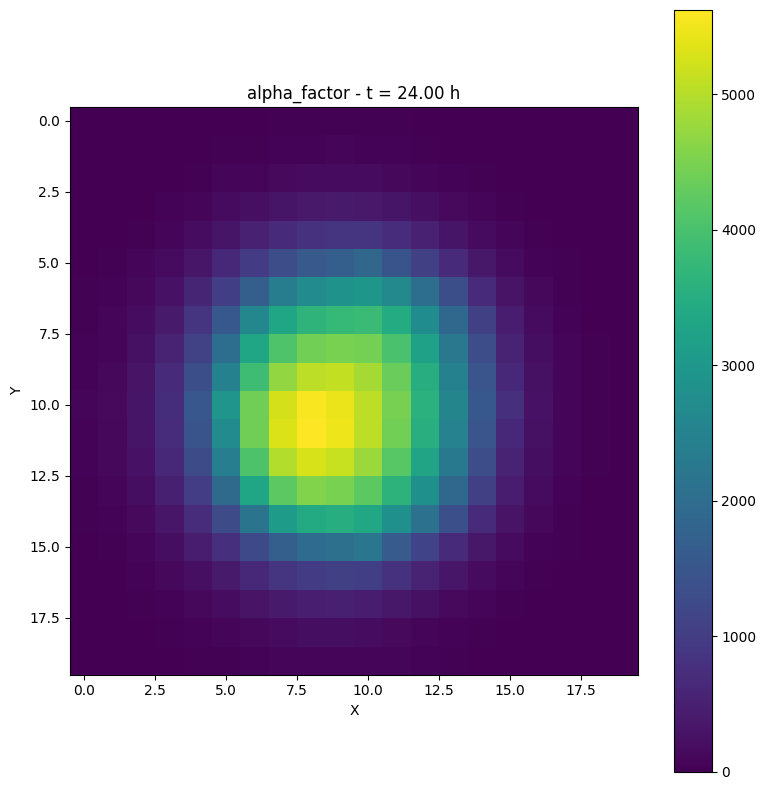

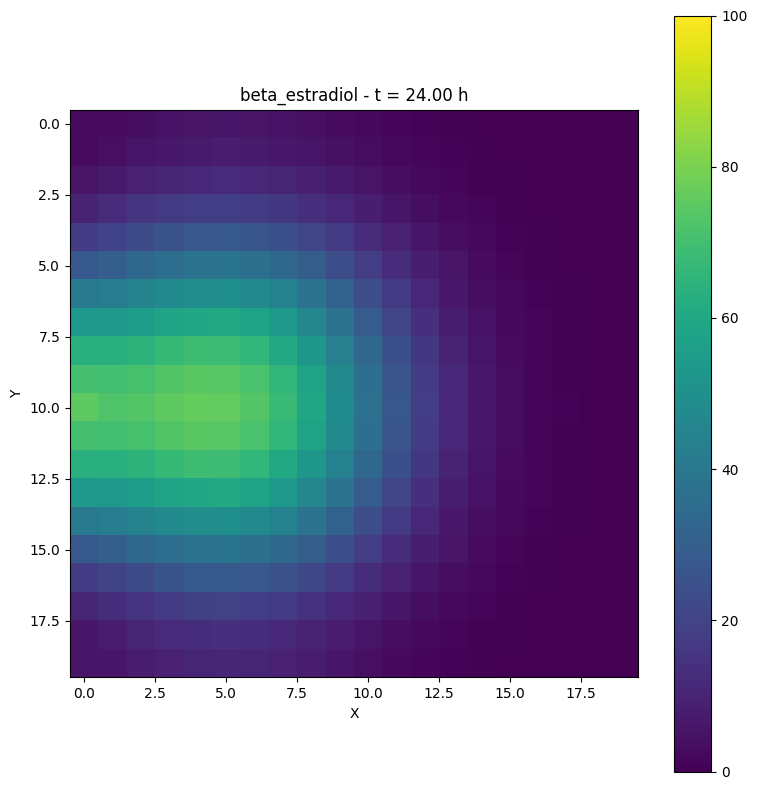

In [3]:
resultsCC, modelCC = quick_two_strain_relay()

In [5]:
def plot_strain_growth(results, model, figsize=(12, 8), average_over_space=True, specific_locations=None):
    """
    Plot the growth of each strain over time from simulation results.
    
    Args:
        results: Simulation results from the simulate method
        model: The SpatialMultiStrainModel instance
        figsize: Figure size (width, height) in inches
        average_over_space: If True, plot the average population across the entire grid
                           If False, plot the total population across the entire grid
        specific_locations: List of (row, col) coordinates to plot strain growth at specific locations
                           If None, only the spatial average/total is plotted
    
    Returns:
        matplotlib figure instance
    """
    t = results['t']
    n_strains = len(model.strains)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create color map for strains
    colors = plt.cm.tab10.colors
    
    # Plot average/total growth for each strain
    for strain_idx, strain in enumerate(model.strains):
        strain_id = strain.strain_id
        populations = results['population_grids'][strain_idx]
        
        if average_over_space:
            # Calculate mean population across the grid for each time point
            values = [np.mean(pop) for pop in populations]
            label = f"{strain_id} (Avg)"
        else:
            # Calculate total population across the grid for each time point
            values = [np.sum(pop) for pop in populations]
            label = f"{strain_id} (Total)"
        
        # Plot the strain growth
        ax.plot(t, values, label=label, color=colors[strain_idx % len(colors)], 
                linewidth=2.5, marker='', alpha=0.8)
    
    # Plot growth at specific locations if provided
    if specific_locations:
        linestyles = ['-', '--', '-.', ':']
        markers = ['o', 's', '^', 'd', 'x']
        
        for loc_idx, (row, col) in enumerate(specific_locations):
            for strain_idx, strain in enumerate(model.strains):
                strain_id = strain.strain_id
                populations = results['population_grids'][strain_idx]
                
                # Extract population at this specific location over time
                values = [pop[row, col] for pop in populations]
                
                # Use different line style for different locations
                ls = linestyles[loc_idx % len(linestyles)]
                marker = markers[loc_idx % len(markers)]
                
                # Plot with thinner lines and markers for specific locations
                ax.plot(t, values, 
                        label=f"{strain_id} at ({row},{col})", 
                        color=colors[strain_idx % len(colors)],
                        linestyle=ls, 
                        marker=marker, 
                        markersize=5,
                        markevery=max(1, len(t)//10),  # Show marker every few points
                        linewidth=1.5,
                        alpha=0.6)
    
    # Add grid and labels
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time (hours)', fontsize=12)
    
    if average_over_space:
        ax.set_ylabel('Average Population Density', fontsize=12)
        ax.set_title('Average Strain Growth Over Time', fontsize=14)
    else:
        ax.set_ylabel('Total Population', fontsize=12)
        ax.set_title('Total Strain Growth Over Time', fontsize=14)
    
    # Add legend with a reasonable number of columns
    n_items = n_strains * (1 + len(specific_locations) if specific_locations else 1)
    n_cols = max(1, min(3, n_items // 4 + 1))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=n_cols)
    
    # Adjust layout to make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.78)
    
    return fig

# Example usage:
# fig = plot_strain_growth(results, model)
# fig = plot_strain_growth(results, model, average_over_space=False)  # For total rather than average
# fig = plot_strain_growth(results, model, specific_locations=[(20, 20), (30, 40)])  # With specific locations

def create_growth_dashboard(results, model, time_points=None, figsize=(15, 12)):
    """
    Create a comprehensive dashboard to visualize strain growth and behavior.
    
    Args:
        results: Simulation results from the simulate method
        model: The SpatialMultiStrainModel instance
        time_points: List of time indices to display spatial distributions
                    If None, 4 evenly spaced time points will be selected
        figsize: Figure size for the entire dashboard
        
    Returns:
        matplotlib figure instance
    """
    t = results['t']
    n_strains = len(model.strains)
    
    # Select time points if not provided
    if time_points is None:
        time_points = [0, len(t)//3, 2*len(t)//3, -1]  # Beginning, 1/3, 2/3, end
    
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2)
    
    # Plot 1: Average strain growth
    ax1 = fig.add_subplot(gs[0, 0])
    for strain_idx, strain in enumerate(model.strains):
        strain_id = strain.strain_id
        populations = results['population_grids'][strain_idx]
        
        # Calculate mean population across the grid for each time point
        values = [np.mean(pop) for pop in populations]
        
        # Plot the strain growth
        ax1.plot(t, values, label=f"{strain_id}", linewidth=2)
    
    ax1.grid(True, alpha=0.3)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Average Population Density')
    ax1.set_title('Average Strain Growth Over Time')
    ax1.legend()
    
    # Plot 2: Total strain growth
    ax2 = fig.add_subplot(gs[0, 1])
    for strain_idx, strain in enumerate(model.strains):
        strain_id = strain.strain_id
        populations = results['population_grids'][strain_idx]
        
        # Calculate total population across the grid for each time point
        values = [np.sum(pop) for pop in populations]
        
        # Plot the strain growth
        ax2.plot(t, values, label=f"{strain_id}", linewidth=2)
    
    ax2.grid(True, alpha=0.3)
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Total Population')
    ax2.set_title('Total Strain Population Over Time')
    ax2.legend()
    
    # Plot 3: Relative proportions (percentage of total)
    ax3 = fig.add_subplot(gs[1, 0])
    total_by_time = np.zeros(len(t))
    
    # Calculate total population at each time point
    for strain_idx in range(n_strains):
        populations = results['population_grids'][strain_idx]
        for t_idx, pop in enumerate(populations):
            total_by_time[t_idx] += np.sum(pop)
    
    # Plot proportion for each strain
    for strain_idx, strain in enumerate(model.strains):
        strain_id = strain.strain_id
        populations = results['population_grids'][strain_idx]
        
        # Calculate proportion of total at each time point
        proportions = []
        for t_idx, pop in enumerate(populations):
            if total_by_time[t_idx] > 0:
                proportions.append(100 * np.sum(pop) / total_by_time[t_idx])
            else:
                proportions.append(0)
        
        # Plot the strain proportion
        ax3.plot(t, proportions, label=f"{strain_id}", linewidth=2)
    
    ax3.grid(True, alpha=0.3)
    ax3.set_xlabel('Time (hours)')
    ax3.set_ylabel('Percentage of Total Population')
    ax3.set_title('Relative Strain Proportions Over Time')
    ax3.set_ylim(0, 100)
    ax3.legend()
    
    # Plot 4: Growth rates
    ax4 = fig.add_subplot(gs[1, 1])
    for strain_idx, strain in enumerate(model.strains):
        strain_id = strain.strain_id
        populations = results['population_grids'][strain_idx]
        
        # Calculate average population at each time point
        avg_pop = [np.mean(pop) for pop in populations]
        
        # Calculate growth rate: (dP/dt)/P
        growth_rates = []
        for i in range(1, len(t)):
            dt = t[i] - t[i-1]
            if avg_pop[i-1] > 0:
                rate = (avg_pop[i] - avg_pop[i-1]) / (dt * avg_pop[i-1])
                growth_rates.append(rate)
            else:
                growth_rates.append(0)
        
        # Plot growth rate (skip first point since we don't have a rate for it)
        ax4.plot(t[1:], growth_rates, label=f"{strain_id}", linewidth=2)
    
    ax4.grid(True, alpha=0.3)
    ax4.set_xlabel('Time (hours)')
    ax4.set_ylabel('Relative Growth Rate (1/hour)')
    ax4.set_title('Strain Growth Rates Over Time')
    ax4.legend()
    
    # Plot 5: Spatial distribution at selected time points
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')
    ax5.set_title('Spatial Distribution of Strains at Selected Time Points')
    
    # Create small subplots for each time point
    inner_gs = gs[2, :].subgridspec(1, len(time_points), wspace=0.1)
    
    for i, t_idx in enumerate(time_points):
        inner_ax = fig.add_subplot(inner_gs[0, i])
        
        # Create a composite image showing all strains
        composite = np.zeros(model.grid_size + (3,))  # RGB image
        
        # Normalize each strain to [0, 1] and assign a color
        for strain_idx, strain in enumerate(model.strains):
            pop = results['population_grids'][strain_idx][t_idx]
            max_val = np.max(pop) if np.max(pop) > 0 else 1
            normalized = pop / max_val
            
            # Assign color (cycle through primary and secondary colors)
            if strain_idx % 6 == 0:  # Red
                composite[:, :, 0] += normalized
            elif strain_idx % 6 == 1:  # Green
                composite[:, :, 1] += normalized
            elif strain_idx % 6 == 2:  # Blue
                composite[:, :, 2] += normalized
            elif strain_idx % 6 == 3:  # Yellow
                composite[:, :, 0] += normalized
                composite[:, :, 1] += normalized
            elif strain_idx % 6 == 4:  # Magenta
                composite[:, :, 0] += normalized
                composite[:, :, 2] += normalized
            else:  # Cyan
                composite[:, :, 1] += normalized
                composite[:, :, 2] += normalized
        
        # Clip values to [0, 1]
        composite = np.clip(composite, 0, 1)
        
        # Display the composite image
        inner_ax.imshow(composite)
        inner_ax.set_title(f"t = {t[t_idx]:.2f} h")
        inner_ax.set_xticks([])
        inner_ax.set_yticks([])
    
    plt.tight_layout()
    return fig

# Example usage:
#fig = create_growth_dashboard(results, model)

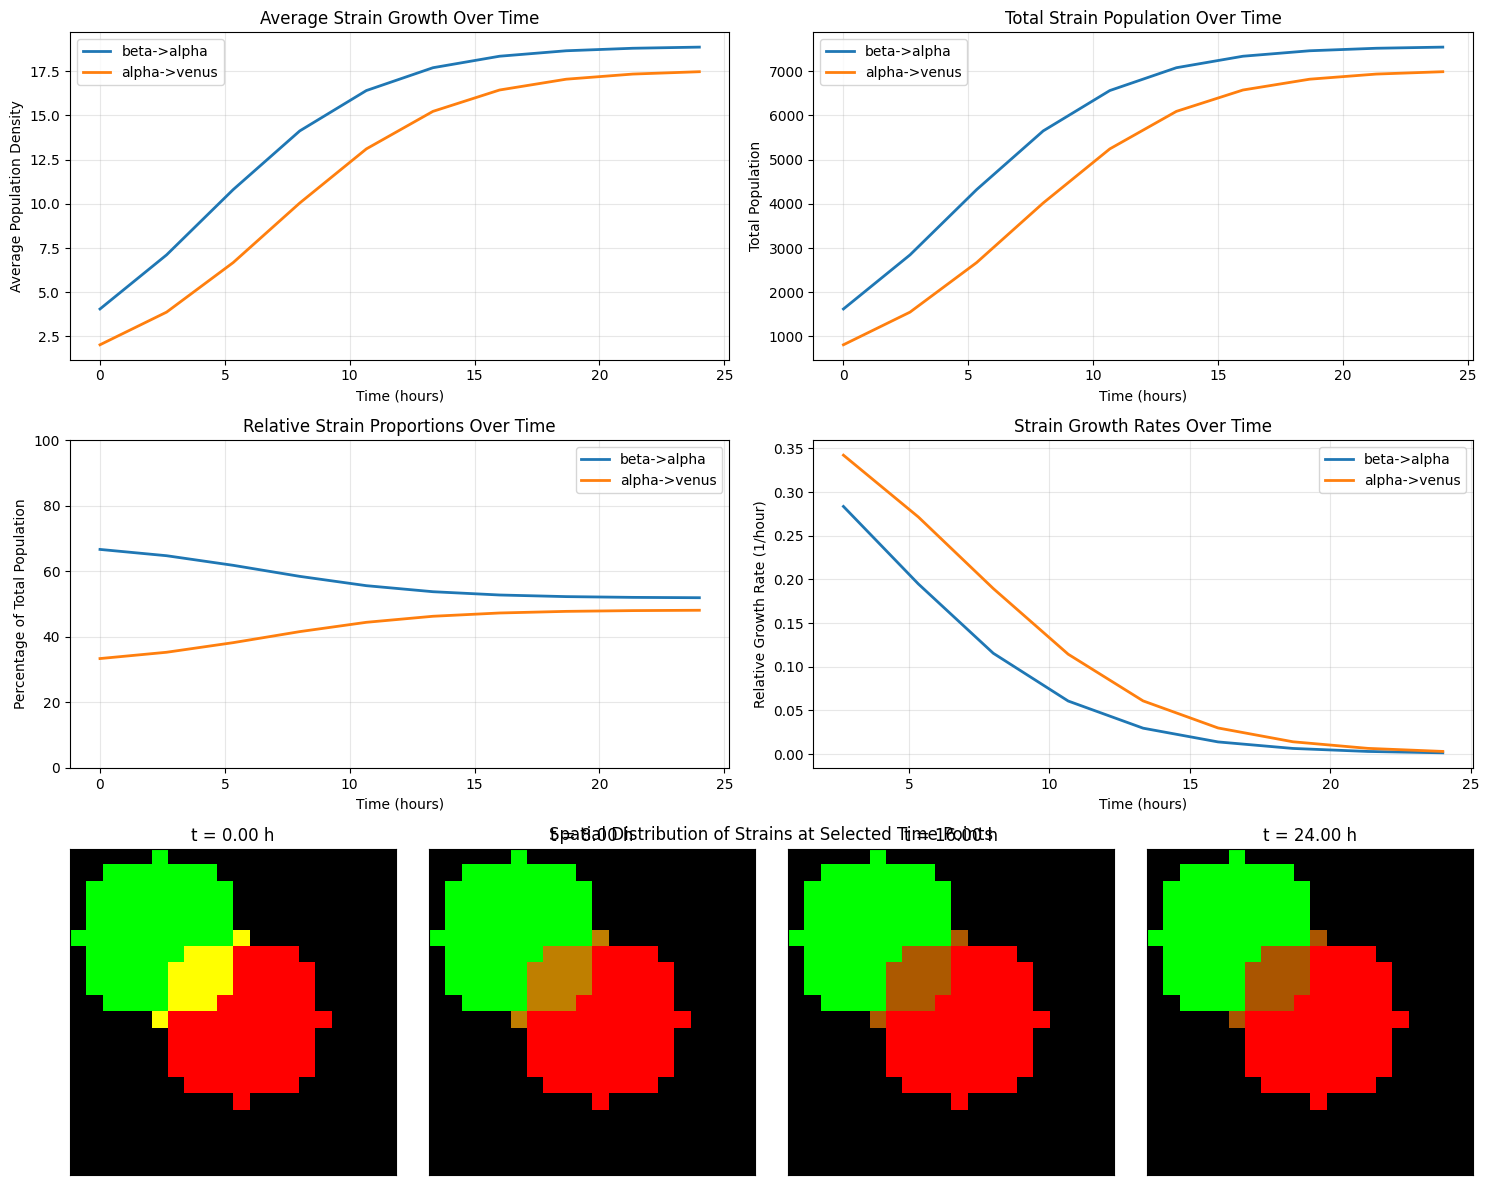

In [6]:
fig = create_growth_dashboard(resultsCC, modelCC)

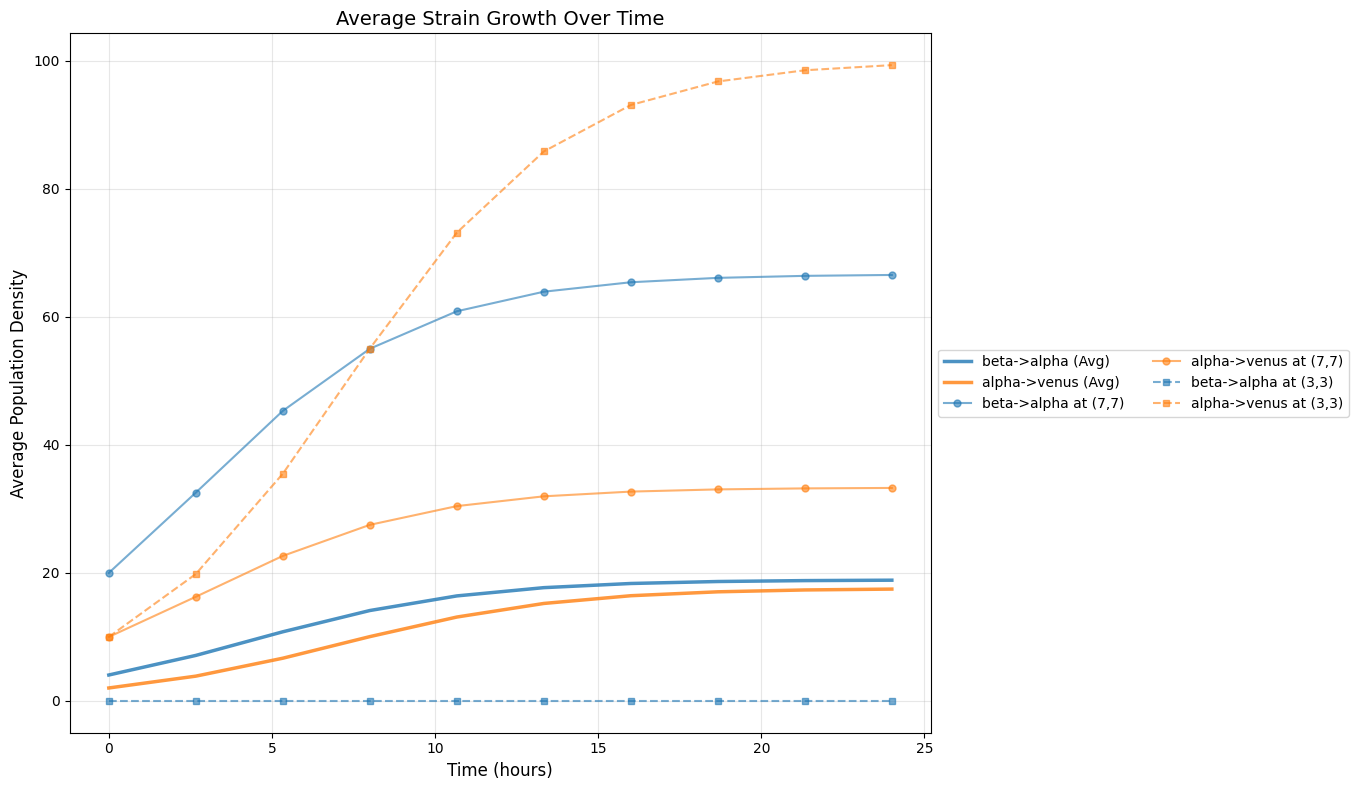

In [8]:
fig = plot_strain_growth(resultsCC, modelCC, specific_locations=[(7, 7), (3, 3)])  # With specific locations